In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:193: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 5722 images belonging to 4 classes.
Found 1430 images belonging to 4 classes.
Training <keras.preprocessing.image.DirectoryIterator object at 0x7f7960437be0>
Validation <keras.preprocessing.image.DirectoryIterator object at 0x7f794ce9ea60>
(32, 224, 224, 3)


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)


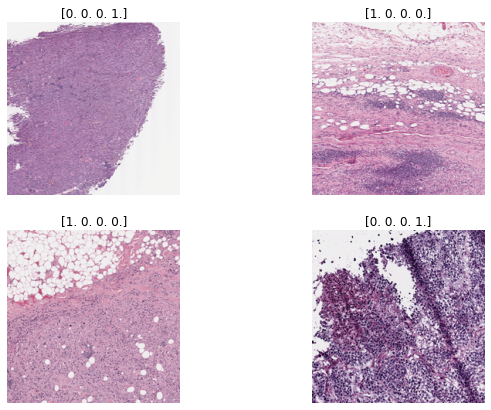

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib as plt
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# create an ImageDataGenerator object with TIFF image format
datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', dtype='float32',validation_split=0.2)

# read TIFF images from a directory
train_data = datagen.flow_from_directory(directory="/content/gdrive/MyDrive/project/TCGA",
                                        target_size=(224, 224),
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        classes = ['TCGA-BRCA','TCGA-COAD','TCGA-LUSC','TCGA-SKCM'],
                                        batch_size=32,
                                        save_to_dir=None,
                                        save_prefix='',
                                        save_format='tiff',
                                        follow_links=False,
                                        subset='training',
                                        shuffle=True,
                                        interpolation='nearest')
# read TIFF images from a directory
val_data = datagen.flow_from_directory(directory="/content/gdrive/MyDrive/project/TCGA",
                                        target_size=(224, 224),
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        classes = ['TCGA-BRCA','TCGA-COAD','TCGA-LUSC','TCGA-SKCM'],
                                        batch_size=32,
                                        save_to_dir=None,
                                        save_prefix='',
                                        save_format='tiff',
                                        follow_links=False,
                                        subset='validation',
                                        shuffle=False,
                                        interpolation='nearest')



print('Training', train_data)
print('Validation', val_data)

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2

batch_size = 32
for i in range(1,5):
    img, label = train_data.next()
    fig.add_subplot(rows, columns, i)
    print(img.shape)   #  (1,256,256,3)
    plt.title(label[0])
    plt.axis('off')
    plt.imshow(img[0])

#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#print(len(X_train))
#test_data = datagen.flow(X_test, y_test, batch_size=32)
#train1_data = datagen.flow(X_train, y_train, batch_size=32)

In [11]:
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,Conv2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import optimizers

import tensorflow as tf
IMAGE_SIZE = 224
LEARNING_RATE = 3e-5

optimizer = optimizers.Adam(lr=LEARNING_RATE)

# load pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet',input_shape=(224,224,3),include_top=False)

base_model.trainable = False
# add a global spatial average pooling layer
x = base_model.output

model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(4, activation='softmax'),
        Dense(64, activation='relu')
    ])
        
model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_7   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
 dense_1 (Dense)             (None, 64)                320       
                                                                 
Total params: 7,041,924
Trainable params: 4,420
Non-trainable params: 7,037,504
_________________________________________________________________


In [12]:
history = model.fit(train_data,
                    steps_per_epoch=10,
                    epochs=32,
                    validation_data=val_data)
                    #class_weight=class_weight)

Epoch 1/32


InvalidArgumentError: ignored

In [ ]:
print(x.shape)
x = GlobalAveragePooling2D()(x)
# add a dropout layer for regularization
x = Dropout(0.5)(x)

print(x.shape)

# add a 2D convolutional layer
x = Conv2D(5, kernel_size=(3, 3), activation='relu')(x)

inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.


# add output layers for multiple tasks
output1 = Dense(64, activation='relu')(x)
output1 = Dense(1, activation='softmax', name='output1')(output1)

output2 = Dense(64, activation='relu')(x)
output2 = Dense(1, activation='linear', name='output2')(output2)

# create the final model
model = Model(inputs=inputs, outputs=[output1, output2])

# compile the model with a multi-task loss function
model.compile(optimizer='adam', loss={'output1': 'binary_crossentropy', 'output2': 'mean_squared_error'}, metrics={'output1': 'accuracy', 'output2': 'mae'})



# train the model
history = model.fit_generator(train_data,
                              steps_per_epoch=len(train_data),
                              epochs=20,
                              validation_data=val_data,
                              validation_steps=len(val_data))
